#**유통 판매량 예측 및 재고 최적화**
## **단계3 : 모델링 및 비즈니스 평가**

# **0.미션**

* 단계1 다양한 모델링 수행
    * LSTM, CNN 등을 이용해서 다양한 시계열 모델링 수행
    * 성능 상위 2~3개 모델 선정
* 단계2 데이터 파이프라인 구축
    * test 데이터(raw data)로 부터 예측에 사용할 수 있는 형태로 데이터를 만드는 과정을 하나의 함수로 엮기
* 단계3 비즈니스 평가
    * 단계1에서 선정된 모델에 대해 test셋으로 평균 재고액 평가 수행

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [72]:
%cd /content/drive/MyDrive/취업/KT_AIVLE_SCHOOL/week10/Mini_project6/Product_sales_forecast/

/content/drive/MyDrive/취업/KT_AIVLE_SCHOOL/week10/Mini_project6/Product_sales_forecast


In [73]:
path = 'data/'

### **(2) 라이브러리 설치 및 불러오기**

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Bidirectional, Dropout, Conv1DTranspose, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import L1L2

import warnings
warnings.filterwarnings("ignore")

In [75]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [76]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()

### **(3) 데이터 불러오기**

* **세부 요구사항**
    - 상품별로 저장한 데이터를 불러오시오.

In [77]:
df_3 = joblib.load('data/df_3.pkl')
df_3.head()

,Date,Qty,CustomerCount,Qty_diff,Qty_7,weekday_avg,y,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
1,2014-01-02,9853.0,4422.0,9853.0,9192.428571,6276.737805,15153.0,0,0,1,0,0,0
2,2014-01-03,8647.0,4167.0,-1206.0,9192.428571,7628.457317,15606.0,0,0,0,1,0,0
3,2014-01-04,15153.0,5341.0,6506.0,9192.428571,11864.363636,7900.0,0,0,0,0,1,0
4,2014-01-05,15606.0,5123.0,453.0,9192.428571,12772.810976,7188.0,0,0,0,0,0,1
5,2014-01-06,7900.0,3917.0,-7706.0,9192.428571,7802.484848,8800.0,0,0,0,0,0,0


In [78]:
df_12 = joblib.load('data/df_12.pkl')
df_12.head()

,Date,Qty,CustomerCount,Qty_diff,Qty_7,weekday_avg,y,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
1,2014-01-02,9647.0,4422.0,9647.0,8848.857143,7384.045457,14188.0,0,0,1,0,0,0
2,2014-01-03,8879.0,4167.0,-768.0,8848.857143,8889.493902,14490.0,0,0,0,1,0,0
3,2014-01-04,14188.0,5341.0,5309.0,8848.857143,12842.539394,7614.0,0,0,0,0,1,0
4,2014-01-05,14490.0,5123.0,302.0,8848.857143,13709.823171,7124.0,0,0,0,0,0,1
5,2014-01-06,7614.0,3917.0,-6876.0,8848.857143,9266.999370,8683.0,0,0,0,0,0,0


In [79]:
df_42 = joblib.load('data/df_42.pkl')
df_42.head()

,Date,Qty,CustomerCount,Qty_diff,Qty_7,weekday_avg,y,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
1,2014-01-02,76.0,4422.0,25.0,72.857143,112.012121,78.0,0,0,1,0,0,0
2,2014-01-03,74.0,4167.0,-2.0,72.857143,120.606061,88.0,0,0,0,1,0,0
3,2014-01-04,78.0,5341.0,4.0,72.857143,126.151515,65.0,0,0,0,0,1,0
4,2014-01-05,88.0,5123.0,10.0,72.857143,133.727273,78.0,0,0,0,0,0,1
5,2014-01-06,65.0,3917.0,-23.0,72.857143,90.024242,73.0,0,0,0,0,0,0


# **2.모델링**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_train, x_val, y_train, y_val
        * 원본 데이터에서 일부를 떼어 놓고, 파이프라인 함수를 테스트 해 봅시다.

In [80]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return flattened_X

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

In [81]:
def data_split2(df, target, val_size, timesteps):
    # X, y 분할
    X = df.drop([target, 'Date'], axis=1)
    y = df.loc[:, target]

    # 3차원 구조로 만들기
    X2, y2 = temporalize(X, y, timesteps)

    # 데이터 분할
    X_train, X_valid, y_train, y_valid = train_test_split(X2, y2, test_size=val_size, shuffle=False, random_state=42)

    # 2차원으로 변환하여 스케일러 생성
    scaler_x = MinMaxScaler().fit(flatten(X_train))

    # 3차원 데이터에 스테일러 적용
    X_train_s = scale(X_train, scaler_x)
    X_valid_s = scale(X_valid, scaler_x)

    # y에 대한 스케일링(최적화를 위해)
    scaler_y = MinMaxScaler()
    y_train_s = scaler_y.fit_transform(y_train.reshape(-1,1))
    y_valid_s = scaler_y.transform(y_valid.reshape(-1,1))

    return X_train, X_valid, y_train, y_valid, X_train_s, X_valid_s, y_train_s, y_valid_s, scaler_x, scaler_y

def LSTM_model_training(nfeatures, epochs, timesteps):
    clear_session()

    model = Sequential([LSTM(128, input_shape = (timesteps, nfeatures), return_sequences=True),
                        LSTM(64, return_sequences=True),
                        LSTM(32, return_sequences=True),
                        LSTM(16, return_sequences=True),
                        LSTM(8),
                        Dense(1)])

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

    model.summary()

    history = model.fit(X_train_s, y_train_s, validation_data=(X_valid_s, y_valid_s), epochs=epochs, verbose=0).history

    return history, model



def CNN_model_training(nfeatures, epochs, timesteps):
    clear_session()

    model = Sequential([
        Conv1D(filters=128, kernel_size=7, padding="same", strides=1, activation="relu", input_shape=(timesteps, nfeatures)),
        Dropout(0.25),
        Conv1D(filters=64, kernel_size=7, padding="same", strides=1, activation="relu"),
        Dropout(0.25),
        Conv1D(filters=32, kernel_size=7, padding="same", strides=1, activation="relu"),
        Dropout(0.25),
        Conv1D(filters=16, kernel_size=7, padding="same", strides=1, activation="relu"),
        Dropout(0.25),
        Conv1D(filters=8, kernel_size=7, padding="same", strides=1, activation="relu"),
        Dropout(0.25),
        Flatten(),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=1e-4), loss="mse", metrics=['mae'])

    model.summary()

    history = model.fit(X_train_s, y_train_s, validation_data=(X_valid_s, y_valid_s), epochs=epochs, verbose=0).history

    return history, model

## **(1) LSTM 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [82]:
target = 'y'
val_size = 60
timesteps = 7

X_train, X_valid, y_train, y_valid, X_train_s, X_valid_s, y_train_s, y_valid_s, scaler_x_3, scaler_y_3 = data_split2(df_3, target, val_size, timesteps)

In [83]:
X_train_s.shape, X_valid_s.shape, y_train_s.shape, y_valid_s.shape

((1083, 7, 11), (60, 7, 11), (1083, 1), (60, 1))

* **모델링**

In [84]:
nfeatures = X_train_s.shape[2]
epochs = 50

history, model_ls_3 = LSTM_model_training(nfeatures, epochs, timesteps)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 128)            71680     
                                                                 
 lstm_1 (LSTM)               (None, 7, 64)             49408     
                                                                 
 lstm_2 (LSTM)               (None, 7, 32)             12416     
                                                                 
 lstm_3 (LSTM)               (None, 7, 16)             3136      
                                                                 
 lstm_4 (LSTM)               (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 137449 (536.91 KB)
Trainable params: 13744

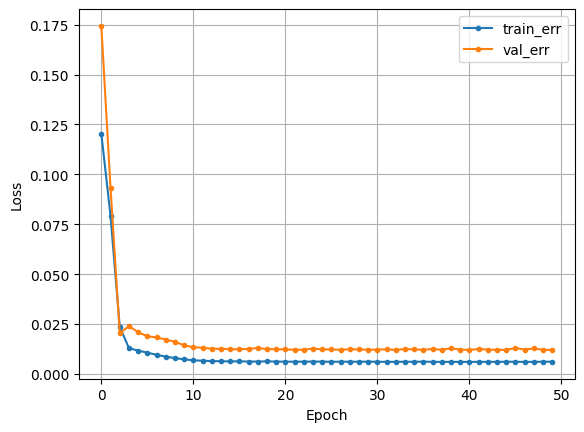

In [85]:
dl_history_plot(history)

In [86]:
pred = model_ls_3.predict(X_valid_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y_3.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('RMSE:', round(mean_squared_error(y_valid, pred, squared=False), 2))
print('MAE :', round(mean_absolute_error(y_valid, pred), 2))
print('MAPE:', round(mean_absolute_percentage_error(y_valid, pred), 2))
print('R2  :', round(r2_score(y_valid, pred), 2))

2/2 [==============================] - 2s 20ms/step
RMSE: 2790.83
MAE : 1919.23
MAPE: 9.053514349541678e+17
R2  : 0.51


In [87]:
# train에 대한 잔차 진단.
pred_tr = model_ls_3.predict(X_train_s)

pred_tr = scaler_y_3.inverse_transform(pred_tr)
pred_tr = pred_tr.reshape(-1,)

# 잔차 : 실제값에서 예측값을 빼서 계산
residuals = y_train - pred_tr

34/34 [==============================] - 0s 11ms/step


* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


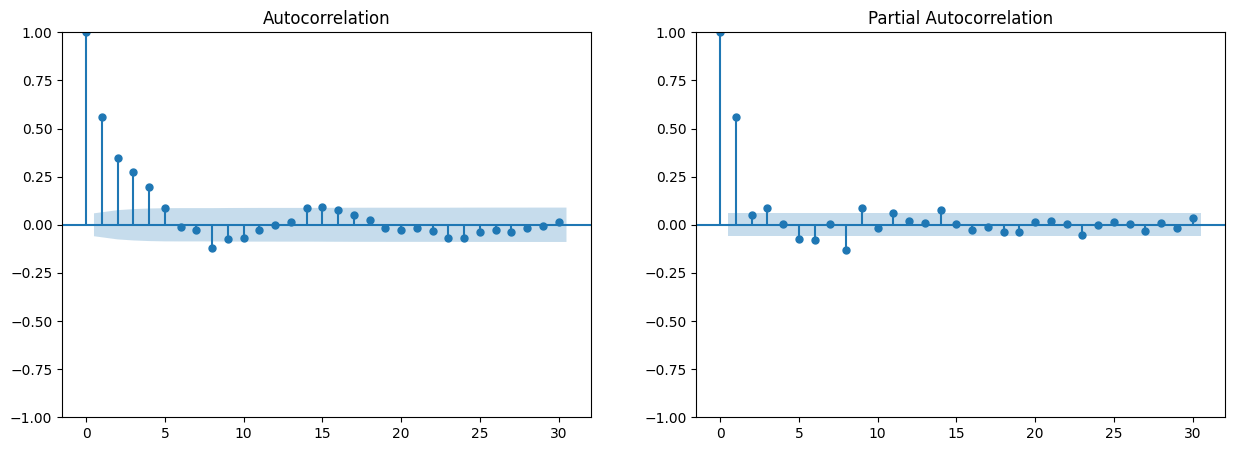

In [88]:
residual_diag(residuals)

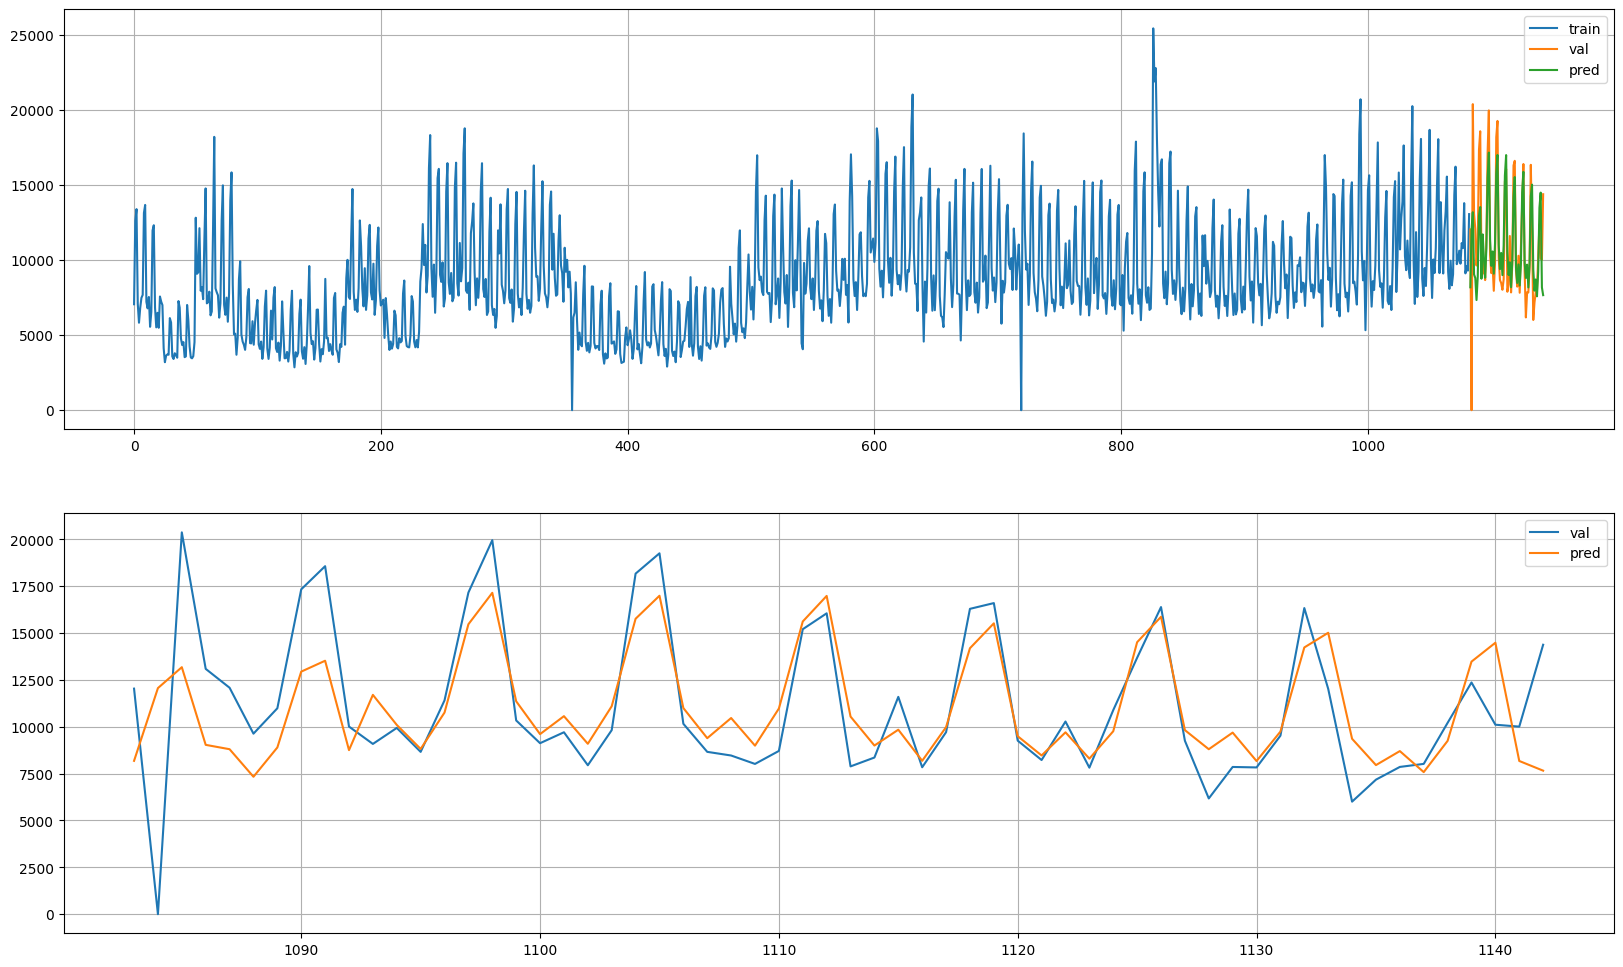

In [89]:
plot_model_result(y_train, y_valid, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [90]:
target = 'y'
val_size = 60
timesteps = 7

X_train, X_valid, y_train, y_valid, X_train_s, X_valid_s, y_train_s, y_valid_s, scaler_x_12, scaler_y_12 = data_split2(df_12, target, val_size, timesteps)

In [91]:
X_train_s.shape, X_valid_s.shape, y_train_s.shape, y_valid_s.shape

((1083, 7, 11), (60, 7, 11), (1083, 1), (60, 1))

* **모델링**

In [92]:
nfeatures = X_train_s.shape[2]
epochs = 50

history, model_ls_12 = LSTM_model_training(nfeatures, epochs, timesteps)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 128)            71680     
                                                                 
 lstm_1 (LSTM)               (None, 7, 64)             49408     
                                                                 
 lstm_2 (LSTM)               (None, 7, 32)             12416     
                                                                 
 lstm_3 (LSTM)               (None, 7, 16)             3136      
                                                                 
 lstm_4 (LSTM)               (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 137449 (536.91 KB)
Trainable params: 13744

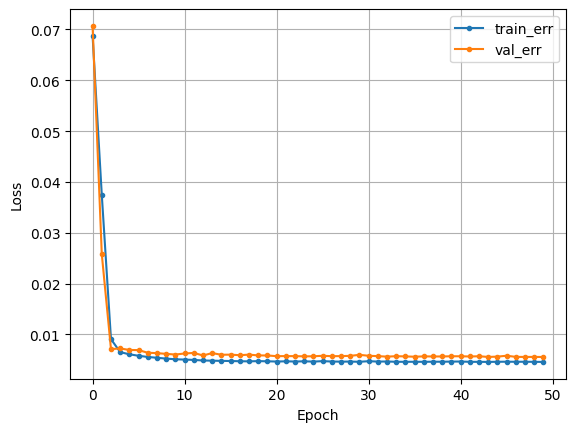

In [93]:
dl_history_plot(history)

In [94]:
pred = model_ls_12.predict(X_valid_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y_12.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('RMSE:', round(mean_squared_error(y_valid, pred, squared=False), 2))
print('MAE :', round(mean_absolute_error(y_valid, pred), 2))
print('MAPE:', round(mean_absolute_percentage_error(y_valid, pred), 2))
print('R2  :', round(r2_score(y_valid, pred), 2))

2/2 [==============================] - 3s 15ms/step
RMSE: 2768.24
MAE : 1754.43
MAPE: 1.1882827514662006e+18
R2  : 0.38


In [95]:
# train에 대한 잔차 진단.
pred_tr = model_ls_12.predict(X_train_s)

pred_tr = scaler_y_12.inverse_transform(pred_tr)
pred_tr = pred_tr.reshape(-1,)

# 잔차 : 실제값에서 예측값을 빼서 계산
residuals = y_train - pred_tr

34/34 [==============================] - 0s 12ms/step


* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


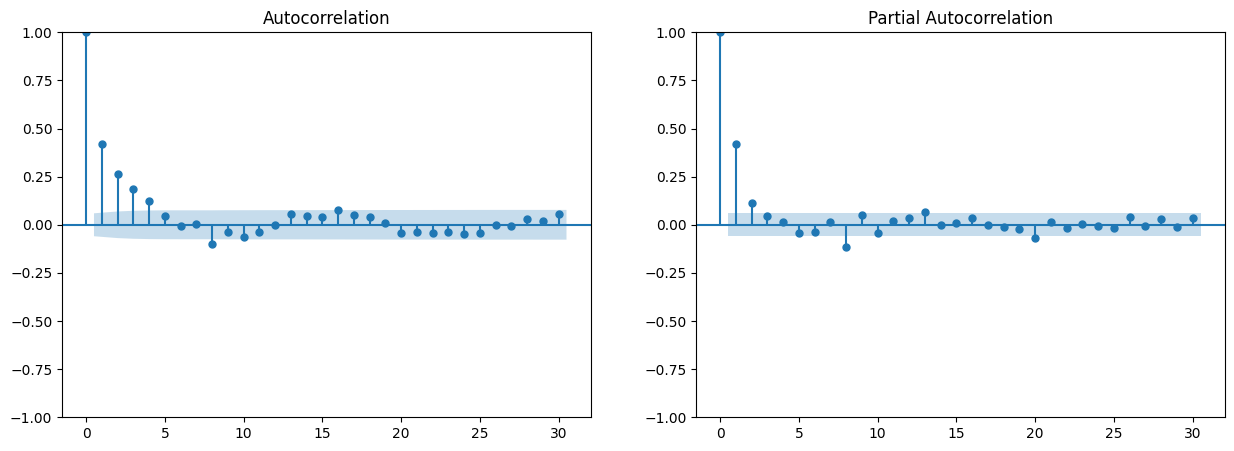

In [96]:
residual_diag(residuals)

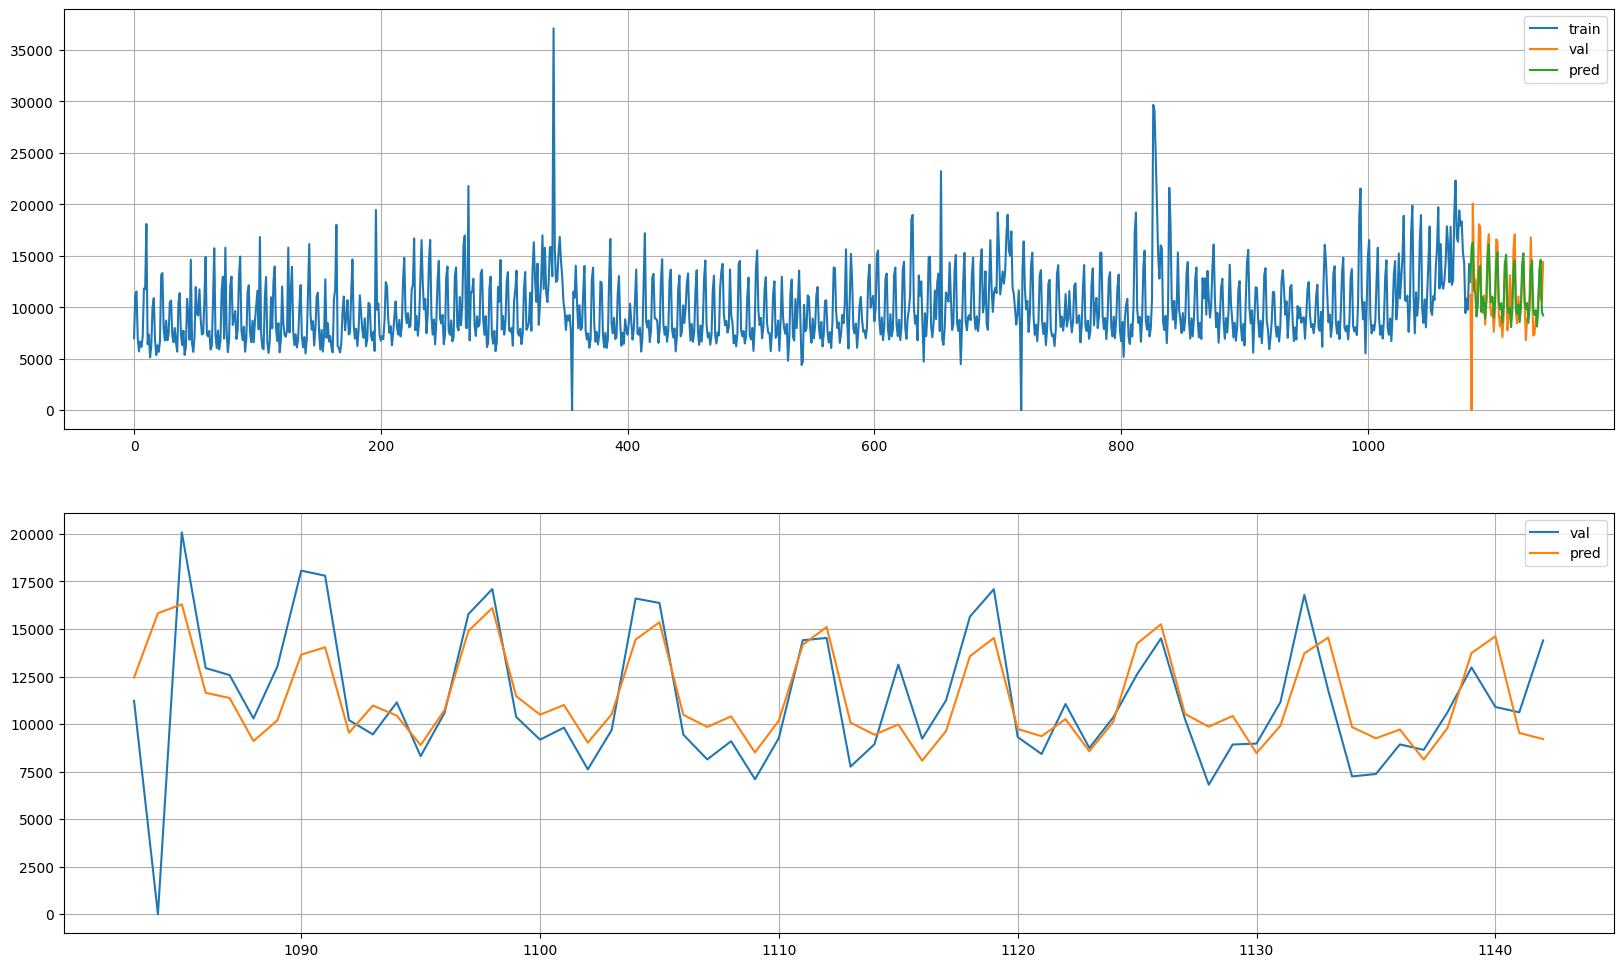

In [97]:
plot_model_result(y_train, y_valid, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [98]:
target = 'y'
val_size = 60
timesteps = 7

X_train, X_valid, y_train, y_valid, X_train_s, X_valid_s, y_train_s, y_valid_s, scaler_x_42, scaler_y_42 = data_split2(df_42, target, val_size, timesteps)

In [99]:
X_train_s.shape, X_valid_s.shape, y_train_s.shape, y_valid_s.shape

((1086, 7, 11), (60, 7, 11), (1086, 1), (60, 1))

* **모델링**

In [100]:
nfeatures = X_train_s.shape[2]
epochs = 50

history, model_ls_42 = LSTM_model_training(nfeatures, epochs, timesteps)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 128)            71680     
                                                                 
 lstm_1 (LSTM)               (None, 7, 64)             49408     
                                                                 
 lstm_2 (LSTM)               (None, 7, 32)             12416     
                                                                 
 lstm_3 (LSTM)               (None, 7, 16)             3136      
                                                                 
 lstm_4 (LSTM)               (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 137449 (536.91 KB)
Trainable params: 13744

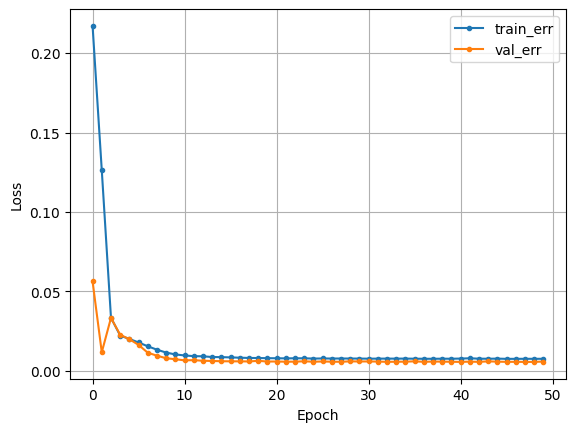

In [101]:
dl_history_plot(history)

In [102]:
pred = model_ls_42.predict(X_valid_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y_42.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('RMSE:', round(mean_squared_error(y_valid, pred, squared=False), 2))
print('MAE :', round(mean_absolute_error(y_valid, pred), 2))
print('MAPE:', round(mean_absolute_percentage_error(y_valid, pred), 2))
print('R2  :', round(r2_score(y_valid, pred), 2))

2/2 [==============================] - 3s 17ms/step
RMSE: 11.57
MAE : 9.04
MAPE: 0.11
R2  : 0.42


In [103]:
# train에 대한 잔차 진단.
pred_tr = model_ls_42.predict(X_train_s)

pred_tr = scaler_y_42.inverse_transform(pred_tr)
pred_tr = pred_tr.reshape(-1,)

# 잔차 : 실제값에서 예측값을 빼서 계산
residuals = y_train - pred_tr

34/34 [==============================] - 0s 12ms/step


* 정규성 검정(> 0.05) :  0.00139
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


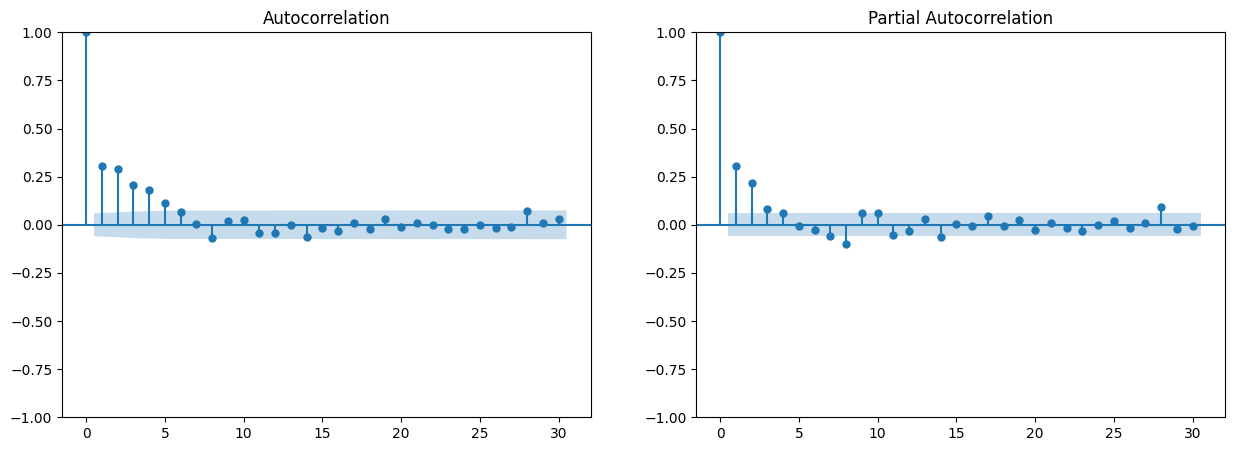

In [104]:
residual_diag(residuals)

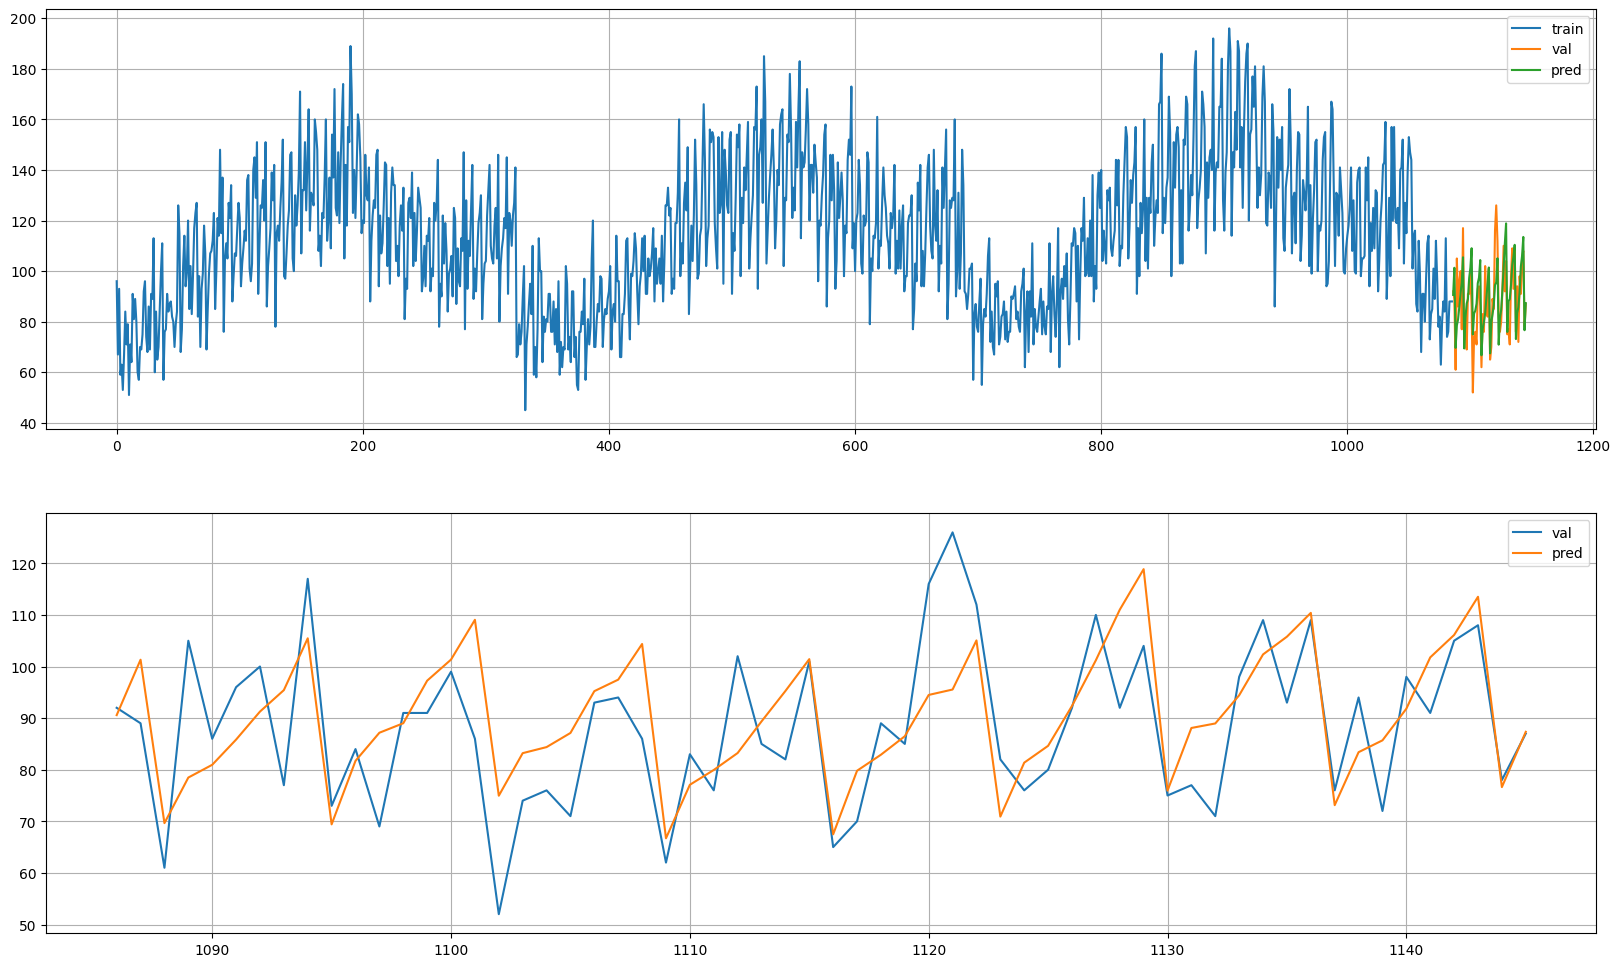

In [105]:
plot_model_result(y_train, y_valid, pred)

## **(2) CNN 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [106]:
target = 'y'
val_size = 60
timesteps = 7

X_train, X_valid, y_train, y_valid, X_train_s, X_valid_s, y_train_s, y_valid_s, scaler_x_3, scaler_y_3 = data_split2(df_3, target, val_size, timesteps)

In [107]:
X_train_s.shape, X_valid_s.shape, y_train_s.shape, y_valid_s.shape

((1083, 7, 11), (60, 7, 11), (1083, 1), (60, 1))

* **모델링**

In [108]:
nfeatures = X_train_s.shape[2]
epochs = 50

history, model_cnn_3 = CNN_model_training(nfeatures, epochs, timesteps)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 128)            9984      
                                                                 
 dropout (Dropout)           (None, 7, 128)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 64)             57408     
                                                                 
 dropout_1 (Dropout)         (None, 7, 64)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 7, 32)             14368     
                                                                 
 dropout_2 (Dropout)         (None, 7, 32)             0         
                                                                 
 conv1d_3 (Conv1D)           (None, 7, 16)             3

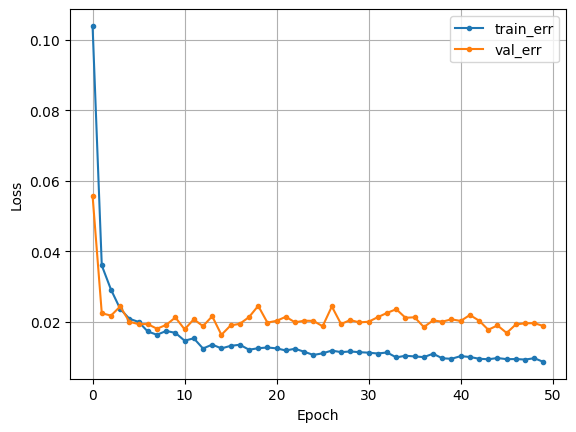

In [109]:
dl_history_plot(history)

In [110]:
pred = model_cnn_3.predict(X_valid_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y_3.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('RMSE:', round(mean_squared_error(y_valid, pred, squared=False), 2))
print('MAE :', round(mean_absolute_error(y_valid, pred), 2))
print('MAPE:', round(mean_absolute_percentage_error(y_valid, pred), 2))
print('R2  :', round(r2_score(y_valid, pred), 2))

2/2 [==============================] - 0s 9ms/step
RMSE: 3478.44
MAE : 2546.95
MAPE: 8.324997003178848e+17
R2  : 0.23


In [111]:
# train에 대한 잔차 진단.
pred_tr = model_cnn_3.predict(X_train_s)

pred_tr = scaler_y_3.inverse_transform(pred_tr)
pred_tr = pred_tr.reshape(-1,)

# 잔차 : 실제값에서 예측값을 빼서 계산
residuals = y_train - pred_tr

34/34 [==============================] - 0s 6ms/step


* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


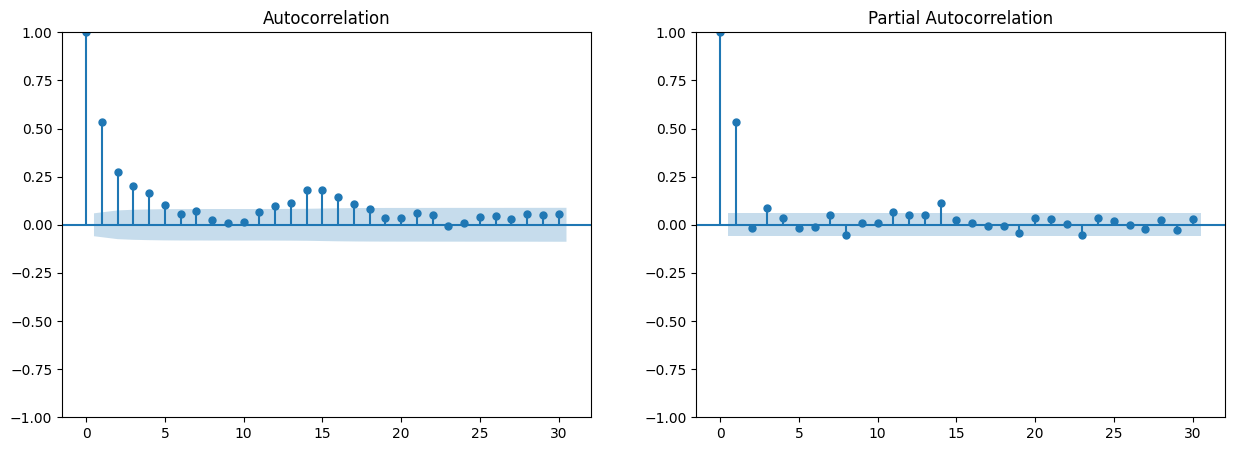

In [112]:
residual_diag(residuals)

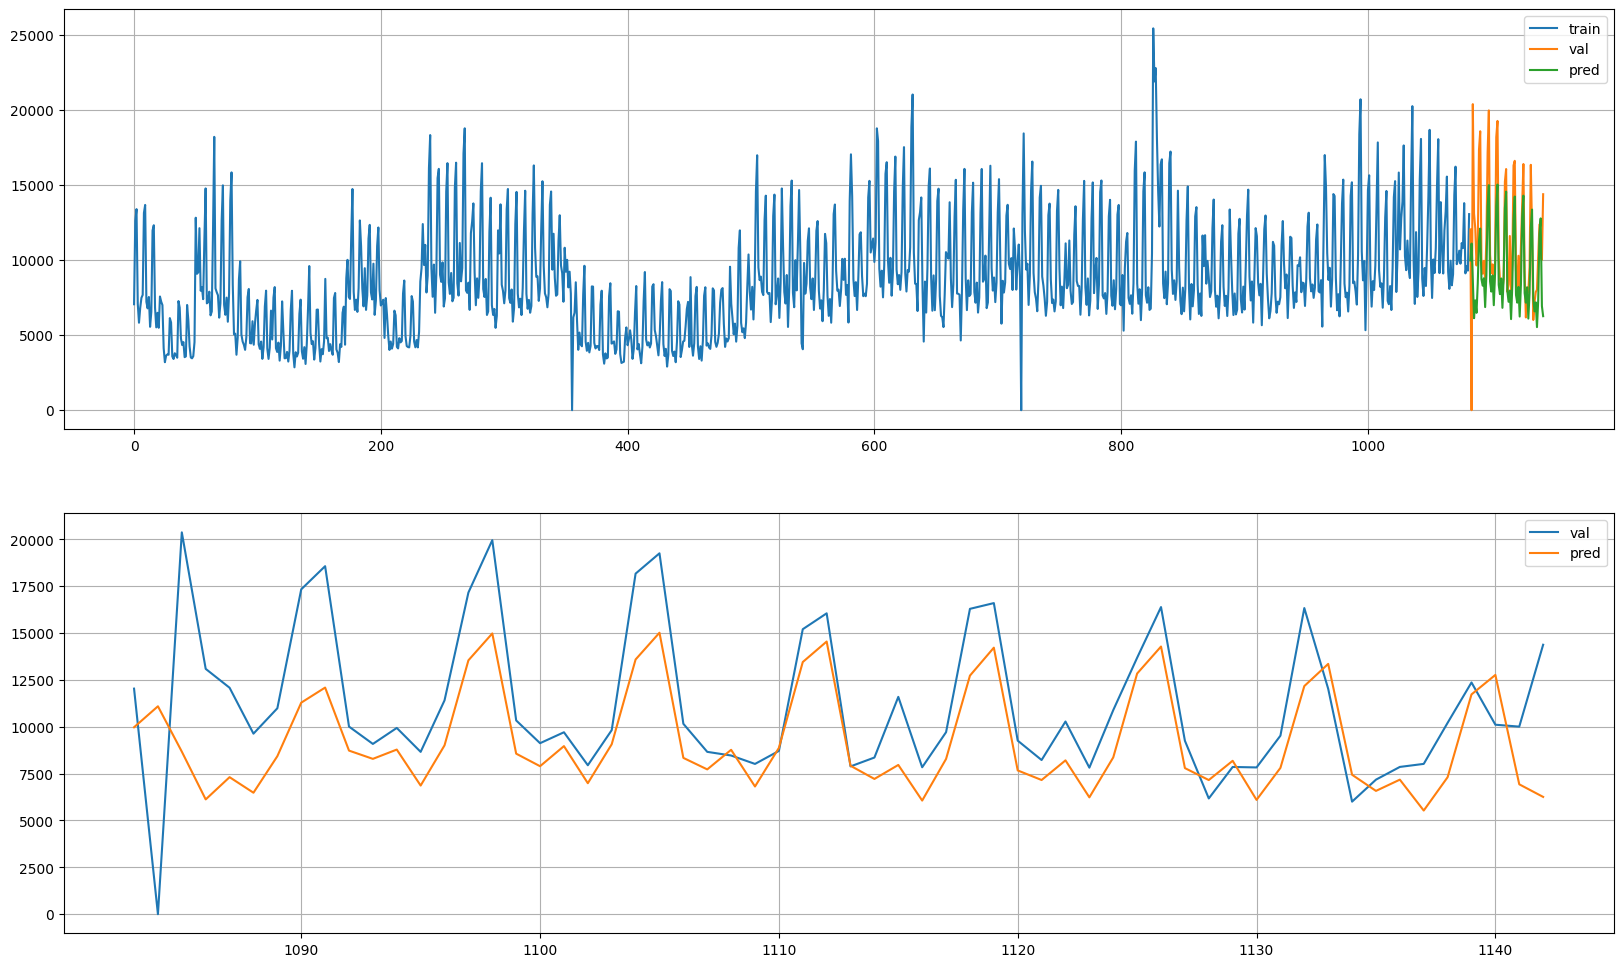

In [113]:
plot_model_result(y_train, y_valid, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [114]:
target = 'y'
val_size = 60
timesteps = 7

X_train, X_valid, y_train, y_valid, X_train_s, X_valid_s, y_train_s, y_valid_s, scaler_x_12, scaler_y_12 = data_split2(df_12, target, val_size, timesteps)

In [115]:
X_train_s.shape, X_valid_s.shape, y_train_s.shape, y_valid_s.shape

((1083, 7, 11), (60, 7, 11), (1083, 1), (60, 1))

* **모델링**

In [116]:
nfeatures = X_train_s.shape[2]
epochs = 50

history, model_cnn_12 = CNN_model_training(nfeatures, epochs, timesteps)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 128)            9984      
                                                                 
 dropout (Dropout)           (None, 7, 128)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 64)             57408     
                                                                 
 dropout_1 (Dropout)         (None, 7, 64)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 7, 32)             14368     
                                                                 
 dropout_2 (Dropout)         (None, 7, 32)             0         
                                                                 
 conv1d_3 (Conv1D)           (None, 7, 16)             3

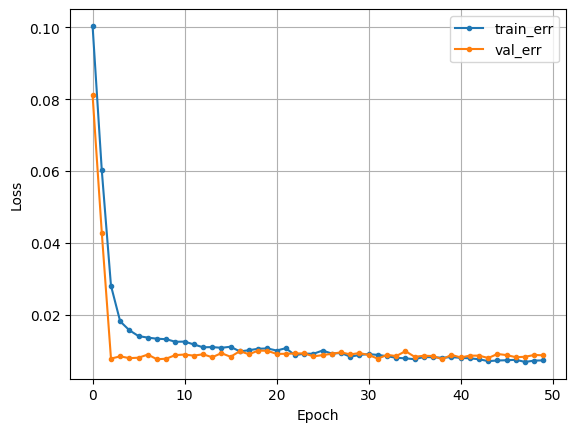

In [117]:
dl_history_plot(history)

In [118]:
pred = model_cnn_12.predict(X_valid_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y_12.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('RMSE:', round(mean_squared_error(y_valid, pred, squared=False), 2))
print('MAE :', round(mean_absolute_error(y_valid, pred), 2))
print('MAPE:', round(mean_absolute_percentage_error(y_valid, pred), 2))
print('R2  :', round(r2_score(y_valid, pred), 2))

2/2 [==============================] - 0s 12ms/step
RMSE: 3447.74
MAE : 2443.9
MAPE: 9.795486053189725e+17
R2  : 0.03


In [119]:
# train에 대한 잔차 진단.
pred_tr = model_cnn_12.predict(X_train_s)

pred_tr = scaler_y_12.inverse_transform(pred_tr)
pred_tr = pred_tr.reshape(-1,)

# 잔차 : 실제값에서 예측값을 빼서 계산
residuals = y_train - pred_tr

34/34 [==============================] - 0s 7ms/step


* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


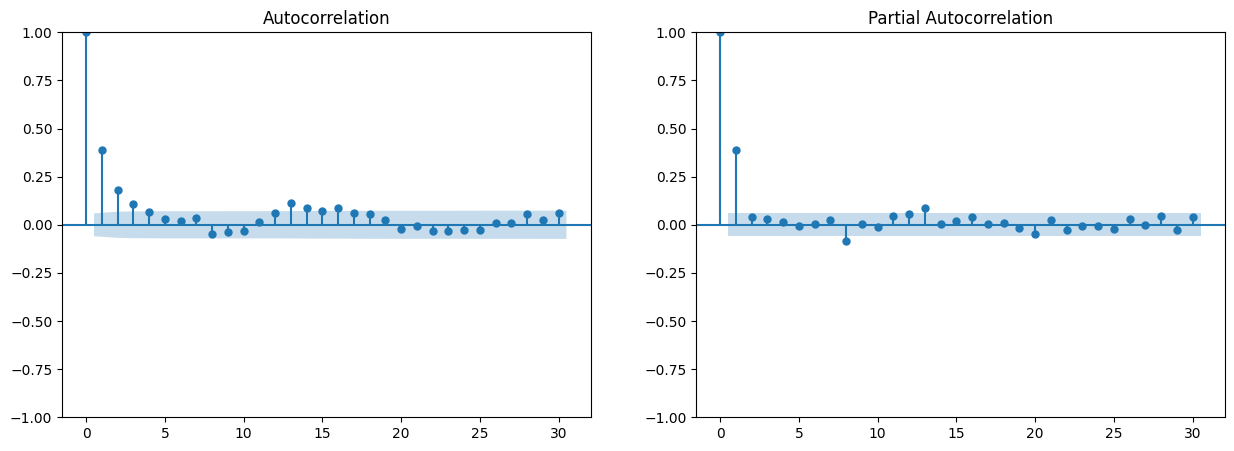

In [120]:
residual_diag(residuals)

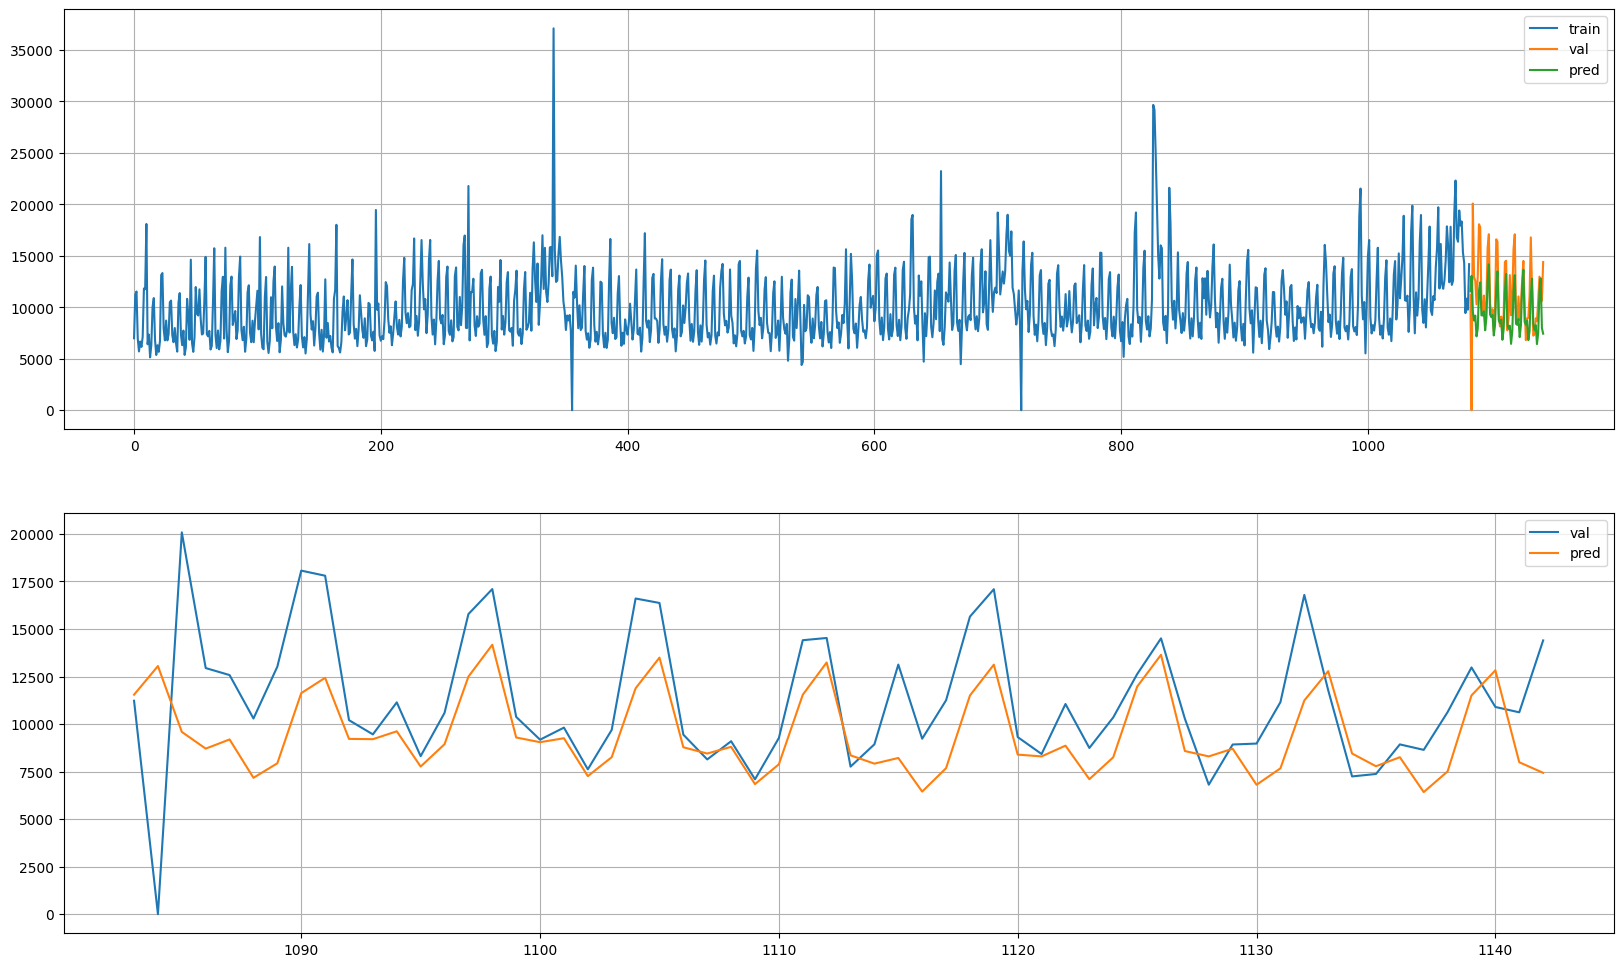

In [121]:
plot_model_result(y_train, y_valid, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [122]:
target = 'y'
val_size = 60
timesteps = 7

X_train, X_valid, y_train, y_valid, X_train_s, X_valid_s, y_train_s, y_valid_s, scaler_x_42, scaler_y_42 = data_split2(df_42, target, val_size, timesteps)

In [123]:
X_train_s.shape, X_valid_s.shape, y_train_s.shape, y_valid_s.shape

((1086, 7, 11), (60, 7, 11), (1086, 1), (60, 1))

* **모델링**

In [124]:
nfeatures = X_train_s.shape[2]
epochs = 50

history, model_cnn_42 = CNN_model_training(nfeatures, epochs, timesteps)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 128)            9984      
                                                                 
 dropout (Dropout)           (None, 7, 128)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 64)             57408     
                                                                 
 dropout_1 (Dropout)         (None, 7, 64)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 7, 32)             14368     
                                                                 
 dropout_2 (Dropout)         (None, 7, 32)             0         
                                                                 
 conv1d_3 (Conv1D)           (None, 7, 16)             3

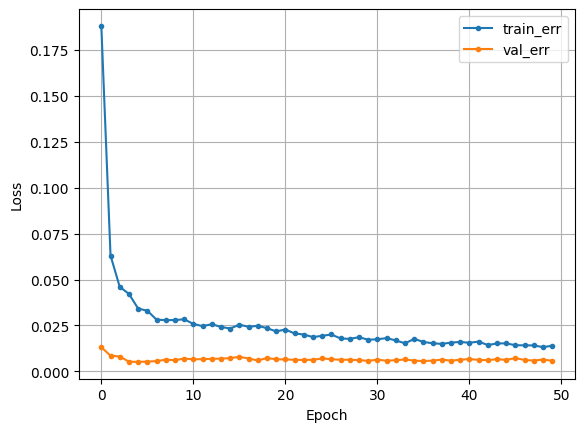

In [125]:
dl_history_plot(history)

In [126]:
pred = model_cnn_42.predict(X_valid_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y_42.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('RMSE:', round(mean_squared_error(y_valid, pred, squared=False), 2))
print('MAE :', round(mean_absolute_error(y_valid, pred), 2))
print('MAPE:', round(mean_absolute_percentage_error(y_valid, pred), 2))
print('R2  :', round(r2_score(y_valid, pred), 2))

2/2 [==============================] - 0s 9ms/step
RMSE: 11.46
MAE : 8.9
MAPE: 0.1
R2  : 0.43


In [127]:
# train에 대한 잔차 진단.
pred_tr = model_cnn_42.predict(X_train_s)

pred_tr = scaler_y_42.inverse_transform(pred_tr)
pred_tr = pred_tr.reshape(-1,)

# 잔차 : 실제값에서 예측값을 빼서 계산
residuals = y_train - pred_tr

34/34 [==============================] - 0s 5ms/step


* 정규성 검정(> 0.05) :  0.05147
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


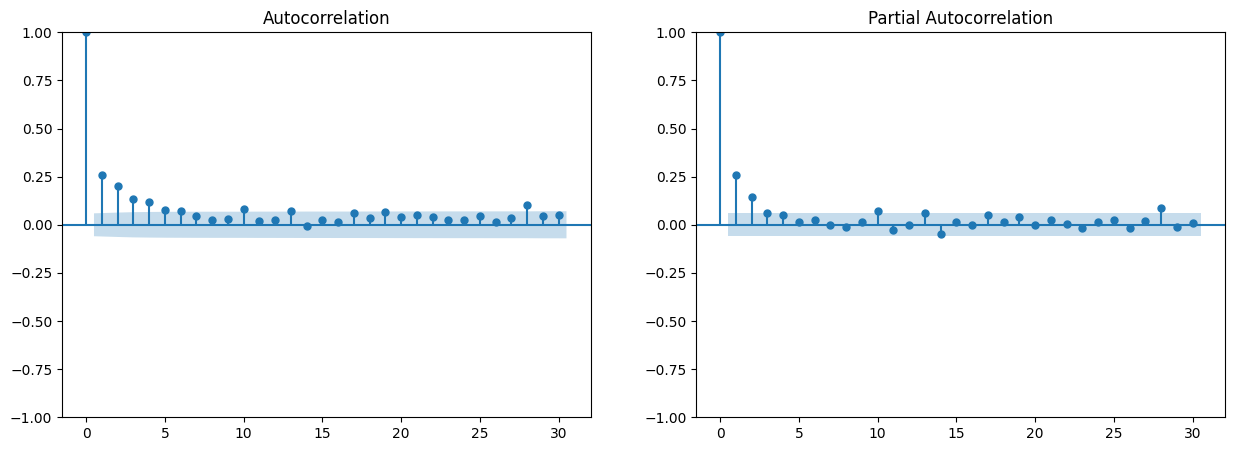

In [128]:
residual_diag(residuals)

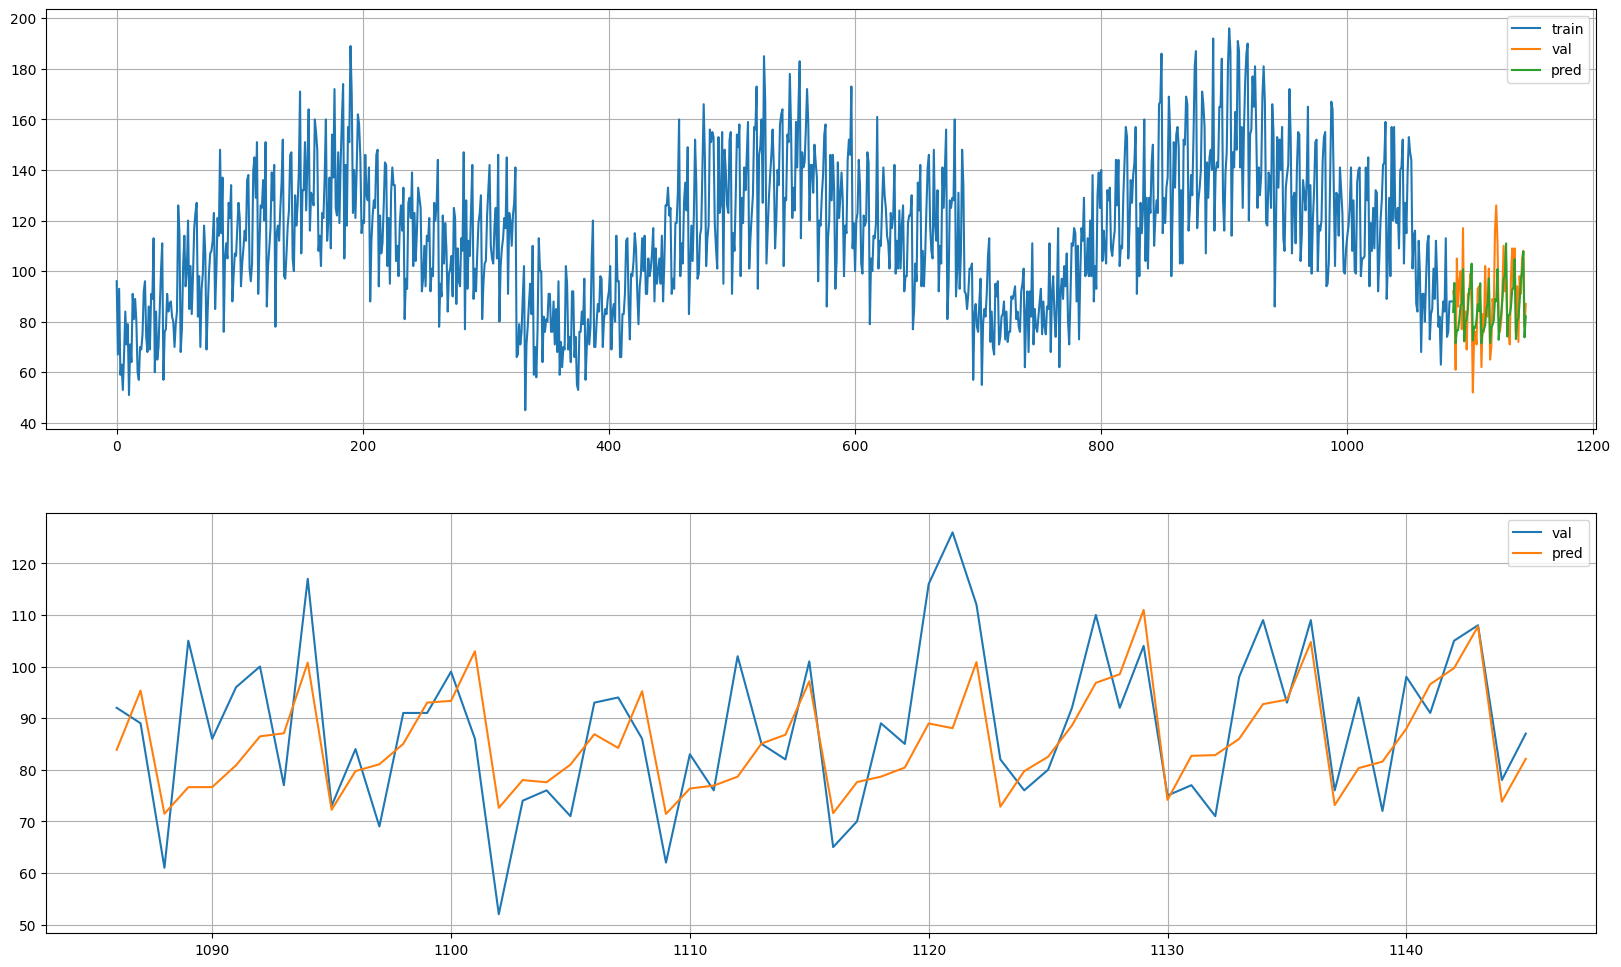

In [129]:
plot_model_result(y_train, y_valid, pred)

# **3.데이터 파이프라인 생성**

* 세부 요구사항
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_test, y_test
        * test set으로 파이프라인 함수를 테스트 해 봅시다.

## **(1) 파이프라인 함수 생성**

In [135]:
def preprocessing4predict(oil_price_test, orders_test, sales_test, products_test, stores_test, STORE_ID, PRODUCT_ID, scaler_x, scaler_y):
    # 데이터 프레임 합치기
    df = sales_test[(sales_test['Store_ID'] == STORE_ID) & (sales_test['Product_ID'] == PRODUCT_ID)]
    df = pd.merge(df, orders_test, how='left')

    # 변수 생성
    df['Qty_diff'] = df['Qty'].diff()
    df['Qty_7'] = df['Qty'].rolling(7).mean()
    df['weekday'] = df['Date'].dt.weekday
    df['y'] = df['Qty'].shift(-2)

    # 요일별 판매량 평균
    weekday_avg = df.groupby('weekday')['Qty'].mean()
    df['weekday_avg'] = df['weekday'].map(weekday_avg)

    # 결측치 처리
    df['CustomerCount'].interpolate(method='linear', inplace=True)
    df['Qty_7'].fillna(method='bfill', inplace=True)
    df.dropna(inplace=True)

    # 가변수화 처리
    object_cols = ['weekday']
    df = pd.get_dummies(df, columns=object_cols, drop_first=True, dtype=int)

    # Store_ID, Product_ID 열 삭제
    df.drop(['Store_ID', 'Product_ID'], axis=1, inplace=True)

    # X, y 분할
    target = 'y'
    X = df.drop([target, 'Date'], axis=1)
    y = df.loc[:, target]

    # 3차원 구조로 만들기
    X2, y2 = temporalize(X, y, timesteps)

    # 3차원 데이터에 스테일러 적용
    X_test = scale(X2, scaler_x)

    # y에 대한 스케일링(최적화를 위해)
    y_test = scaler_y.transform(y2.reshape(-1,1))

    return X_test, y_test

## **(2) test 데이터로 확인**

* test용 데이터셋들 로딩

In [136]:
oil_price_test = pd.read_csv(path + 'test/oil_price_test.csv')
orders_test = pd.read_csv(path + 'test/orders_test.csv')
sales_test = pd.read_csv(path + 'test/sales_test.csv')
products_test = pd.read_csv(path + 'test/products.csv')
stores_test = pd.read_csv(path + 'test/stores.csv')

sales_test['Date'] = pd.to_datetime(sales_test['Date'] )
oil_price_test['Date'] = pd.to_datetime(oil_price_test['Date'] )
orders_test['Date'] = pd.to_datetime(orders_test['Date'] )

In [137]:
X_test_3, y_test_3 = preprocessing4predict(oil_price_test, orders_test, sales_test, products_test, stores_test, 44, 3, scaler_x_3, scaler_y_3)

In [139]:
X_test_12, y_test_12 = preprocessing4predict(oil_price_test, orders_test, sales_test, products_test, stores_test, 44, 12, scaler_x_12, scaler_y_12)

In [140]:
X_test_42, y_test_42 = preprocessing4predict(oil_price_test, orders_test, sales_test, products_test, stores_test, 44, 42, scaler_x_42, scaler_y_42)

* 예측해보기

In [150]:
# 실제 결과 원래 스켕일로 돌리기
y_real = scaler_y_3.inverse_transform(y_test_3)
y_real_3 = y_real.reshape(-1,)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = model_ls_3.predict(X_test_3)
pred = scaler_y_3.inverse_transform(pred)
pred_3 = pred.reshape(-1,)

# 평가
print('RMSE:', round(mean_squared_error(y_real_3, pred_3, squared=False), 2))
print('MAE :', round(mean_absolute_error(y_real_3, pred_3), 2))
print('MAPE:', round(mean_absolute_percentage_error(y_real_3, pred_3), 2))
print('R2  :', round(r2_score(y_real_3, pred_3), 2))

1/1 [==============================] - 0s 31ms/step
RMSE: 2490.24
MAE : 2245.43
MAPE: 0.24
R2  : 0.66


In [151]:
# 실제 결과 원래 스켕일로 돌리기
y_real = scaler_y_12.inverse_transform(y_test_12)
y_real_12 = y_real.reshape(-1,)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = model_ls_12.predict(X_test_12)
pred = scaler_y_12.inverse_transform(pred)
pred_12 = pred.reshape(-1,)

# 평가
print('RMSE:', round(mean_squared_error(y_real_12, pred_12, squared=False), 2))
print('MAE :', round(mean_absolute_error(y_real_12, pred_12), 2))
print('MAPE:', round(mean_absolute_percentage_error(y_real_12, pred_12), 2))
print('R2  :', round(r2_score(y_real_12, pred_12), 2))

1/1 [==============================] - 0s 32ms/step
RMSE: 1762.49
MAE : 1447.11
MAPE: 0.16
R2  : 0.72


In [152]:
# 실제 결과 원래 스켕일로 돌리기
y_real = scaler_y_42.inverse_transform(y_test_42)
y_real_42 = y_real.reshape(-1,)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = model_ls_42.predict(X_test_42)
pred = scaler_y_42.inverse_transform(pred)
pred_42 = pred.reshape(-1,)

# 평가
print('RMSE:', round(mean_squared_error(y_real_42, pred_42, squared=False), 2))
print('MAE :', round(mean_absolute_error(y_real_42, pred_42), 2))
print('MAPE:', round(mean_absolute_percentage_error(y_real_42, pred_42), 2))
print('R2  :', round(r2_score(y_real_42, pred_42), 2))

1/1 [==============================] - 0s 35ms/step
RMSE: 10.59
MAE : 7.58
MAPE: 0.07
R2  : 0.56


# **4.비즈니스 평가**

* 세부 요구사항
    * 기본 시뮬레이션 함수가 제공됩니다.
        * 필요하다면 해당 함수를 수정해서 사용할 수 있습니다.
    * 시뮬레이션 함수 사용하여 재고 평가
        * 실제값, 예측값, 안전재고 수량을 넣고 일평균 재고 금액을 확인합니다.
        * 기회손실수량은 0으로 맞추도록 안전재고 수량을 조절합니다.
        * 평균재고금액을 확인합니다.
    * 데이터는 test 셋을 이용합니다.
        * 예측 후 재고 평가 시, 스케일링된 y를 원래대로 돌려 놓아야 합니다.
            * y_real = y_sacled * (y_max - y_min) + y_min
            * pred_real = pred * (y_max - y_min) + y_min

## **(1) 재고 시뮬레이터**

In [148]:
def inv_simulator(y, pred, safe_stock, price) :

    # 시뮬레이션 df 틀 만들기
    temp = pd.DataFrame({'y':y.reshape(-1,), 'pred':pred.reshape(-1,).round()})

    temp['base_stock'] = 0
    temp['close_stock'] = 0
    temp['order'] = 0
    temp['receive'] = 0

    # 시뮬레이션

    for i in range(len(temp)-2):  # 발주량은 leadtime 후 판매 예측량에 기초하므로 계산을 위해 마지막 leadtime 만큼의 행 제외
        if i == 0 : #첫 행. 2일 전 데이터가 없으므로,
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y']  # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + safe_stock  # 기초재고는 실판매량 + 안전재고로 계산

        elif i == 1 : # 둘째 행, 2일 전 데이터가 없음.
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y'] # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']
        else :      # 나머지 전체 행.
            temp.loc[ i ,'receive'] = temp.loc[ i-2 ,'order']    # 입고량 = 2일전 발주량
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']  # 기초재고 = 입고량 + 전날 기말재고

        # 기말재고 = 기초재고 - 판매량,  만약 0보다 작으면 0으로.
        stock = round(temp.loc[i, 'base_stock'] - temp.loc[i, 'y'])
        temp.loc[i, 'close_stock'] = np.where(stock> 0, stock, 0)

        # 발주량 = 2일후 판매예측량 + 안전재고 - 기말재고,  만약 주문량이 0보다 작으면 0
        order = temp.loc[i+2, 'pred'] + safe_stock - temp.loc[i, 'close_stock']
        temp.loc[i, 'order'] = np.where(order>0,order, 0)

    # 기회손실 = 만약 (기초재고 - 실판매량)이 0보다 작으면, 그만큼이 기회손실
    temp['lost'] = np.where((temp['base_stock'] - temp['y'])<0, (temp['base_stock'] - temp['y']),0).round()

    inventory = temp[:len(temp)-2]

    # 측정지표 계산
    DailyStock = ((inventory['base_stock'] + inventory['close_stock'])/2)
    DailyTurnover = (inventory['y'] + inventory['lost']) / DailyStock

    AvgDailyStock = round(DailyStock.mean(),3)
    AvgDailyStockAmt = AvgDailyStock * price
    turnover = round(DailyTurnover.mean(), 3)
    lost_sum = inventory['lost'].sum()


    print(f'일평균 재고량     : {AvgDailyStock}')
    print(f'일평균 재고 금액  : {AvgDailyStockAmt}')
    print(f'일평균 재고회전율 : {turnover}')
    print(f'기회손실 수량     : {lost_sum}')

    return inventory

## **(2) 예측 결과 시뮬레이션(재고금액 평가)**


In [165]:
# 3번 제품
safe_stock = 2216
price = 8

result_3 = inv_simulator(y_real_3, pred_3, safe_stock, price)

일평균 재고량     : 10293.4
일평균 재고 금액  : 82347.2
일평균 재고회전율 : 1.204
기회손실 수량     : 0.0


In [177]:
# 12번 제품
safe_stock = 4110
price = 6

result_3 = inv_simulator(y_real_12, pred_12, safe_stock, price)

일평균 재고량     : 10953.775
일평균 재고 금액  : 65722.65
일평균 재고회전율 : 1.084
기회손실 수량     : 0.0


In [192]:
# 42번 제품
safe_stock = 36
price = 5

result_3 = inv_simulator(y_real_42, pred_42, safe_stock, price)

일평균 재고량     : 94.2
일평균 재고 금액  : 471.0
일평균 재고회전율 : 1.235
기회손실 수량     : 0.0
